In [57]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import matthews_corrcoef

In [3]:
def preprocess_kdd(df):
    """
    Esegue tutto il preprocessing in NumPy/Pandas.
    """
    # Labels come array NumPy (manteniamo le stringhe originali)
    y_all = df.iloc[:, -1].values
    data = df.iloc[:, :-1].copy()
    
    # Label Encoding per le colonne categoriche
    for col in data.columns:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])

    # Scaling
    scaler = StandardScaler()
    X_all = scaler.fit_transform(data)
    
    return X_all, y_all

In [4]:
def split_dataset(X, y, to_torch=False):
    """
    Split the dataset in NumPy. Se to_torch=True, convert data in tensors.
    """
    normal_mask = (y == 'normal.') | (y == 'normal')
    X_normal = X[normal_mask]
    y_normal = y[normal_mask]
    X_anomaly = X[~normal_mask]
    y_anomaly = y[~normal_mask]

    X_train, X_rest, y_train, y_rest = train_test_split(
        X_normal, y_normal, test_size=0.2, random_state=42
    )

    X_val_test = np.concatenate([X_rest, X_anomaly])
    y_val_test = np.concatenate([y_rest, y_anomaly])
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, test_size=0.5, random_state=42
    )
    
    if to_torch:
        X_train = torch.from_numpy(X_train).float()
        X_val = torch.from_numpy(X_val).float()
        X_test = torch.from_numpy(X_test).float()
    
    return X_train, X_val, X_test, y_val, y_test

In [7]:
df = pd.read_csv('Data/kddcup.data/kddcup.data', header=None)
X_all, y_all = preprocess_kdd(df)

# DAGMM

In [67]:
class DAGMM(nn.Module):

    def __init__(self, enc_dims, estim_dims, types):
        super(DAGMM,self).__init__()

        self.encoder, self.decoder = self.construct_ae(enc_dims)
        self.estim_net = self.construct_estim_net(estim_dims, types)

        n_gmm = estim_dims[-1][1]
        latent_dim = enc_dims[-1][1] + 2 

        self.register_buffer("phi", torch.zeros(n_gmm))
        self.register_buffer("mu", torch.zeros(n_gmm, latent_dim))
        self.register_buffer("cov", torch.zeros(n_gmm, latent_dim, latent_dim))
        self.register_buffer("cov_inverse", torch.zeros(n_gmm, latent_dim, latent_dim))

    def construct_ae(self, dimensions):
        enc_layers = []
        n_dims = len(dimensions)
        for i in range(n_dims):
            enc_layers.append(nn.Linear(dimensions[i][0], dimensions[i][1]))
            if i < n_dims-1:
                enc_layers.append(nn.Tanh())

        rev_dims = dimensions[::-1]
        dec_layers = []
        for i in range(n_dims):
            dec_layers.append(nn.Linear(rev_dims[i][1], rev_dims[i][0]))
            if i < n_dims-1:
                dec_layers.append(nn.Tanh())

        return nn.Sequential(*enc_layers), nn.Sequential( *dec_layers)
    
    def construct_estim_net(self, dimensions, types):
        layers = []
        n_dims = len(dimensions)
        for i in range(n_dims):
            if types[i] == 'Linear':
                if i == 0:
                    layers.append(nn.Linear(dimensions[i][0] + 2, dimensions[i][1]))
                else:
                    layers.append(nn.Linear(dimensions[i][0], dimensions[i][1]))
                if i < n_dims-1:
                    layers.append(nn.Tanh())
                else:
                    layers.append(nn.Softmax(dim = -1))
            if types[i] == 'drop':
                layers.append(nn.Dropout(p=dimensions[i]))
        
        return nn.Sequential(*layers)

    def compute_gmm_params(self, z, gamma):
            N = gamma.size(0)
            sum_gamma = torch.sum(gamma, dim=0)

            # NOTA: Rimuoviamo .detach() e usiamo l'assegnazione diretta ai buffer
            self.phi = sum_gamma / N
            self.mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(1)

            z_mu = z.unsqueeze(1) - self.mu.unsqueeze(0)
            z_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
            self.cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_outer, dim=0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)

    def compute_energy(self, z, flag=True):
            z_mu = z.unsqueeze(1) - self.mu.unsqueeze(0)

            eps = 1e-3
            eye = torch.eye(self.cov.size(-1)).to(self.cov.device)
            cov_reg = self.cov + (eye * eps)
            
            if flag:
                # Aggiorniamo il buffer della matrice inversa
                self.cov_inverse = torch.linalg.inv(cov_reg)

            log_det = 0.5 * torch.linalg.slogdet(2 * torch.pi * cov_reg)[1]

            # Utilizziamo self.cov_inverse (che ora è un buffer ricaricato)
            malan = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * self.cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
            exponent = torch.log(self.phi + eps).unsqueeze(0) + malan - log_det.unsqueeze(0)
            max_val = torch.max(exponent, dim=1, keepdim=True)[0]
            exp_term = torch.exp(exponent - max_val)

            energy = - (max_val.squeeze() + torch.log(torch.sum(exp_term, dim=1) + eps))

            diagonals = torch.diagonal(cov_reg, dim1=-2, dim2=-1)
            p_sigma = torch.sum(1.0 / (diagonals + eps))

            if flag:
                return torch.mean(energy), p_sigma
            else:
                return energy, p_sigma

    def con_loss(self, x, x_rec, z, gamma, lam_energy, lam_cov):
        rec_err = torch.mean((x-x_rec)**2)

        self.compute_gmm_params(z, gamma)

        energy, p_sigma = self.compute_energy(z)
        
        total_loss = rec_err + lam_energy * energy + lam_cov * p_sigma

        return {
            "total": total_loss,
            "rec": rec_err,
            "energy": energy,
            "cov": p_sigma
        }

    def get_estimation_input(self, x, x_rec, z_c):
        # Compute the inpute vector to the estimation net
        # Euclidean dist
        euclidean_dist = torch.norm(x - x_rec, p=2, dim=1, keepdim=True) / torch.norm(x, p=2, dim=1, keepdim=True)
        
        # Cosine Similarity
        cosine_sim = nn.functional.cosine_similarity(x, x_rec, dim=1).unsqueeze(1)
        
        z_combined = torch.cat([z_c, euclidean_dist, cosine_sim], dim=1)
        return z_combined

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            z = self.encoder(x)
            x_rec = self.decoder(z)
            est_in = self.get_estimation_input(x, x_rec, z)

        return self.compute_energy(est_in, False)

    def forward(self, X):
        z = self.encoder(X)
        x_rec = self.decoder(z)

        est_in = self.get_estimation_input(X, x_rec, z)
        gamma = self.estim_net(est_in)

        return x_rec, est_in, gamma
    
def train_dagmm(model, data_tensor, epochs=50, batch_size=1024, lr=1e-3, lam_energy=0.3, lam_cov=0.05):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"training on {device}")
    model.to(device)
    
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'total': [], 'rec': [], 'energy': [], 'cov': []}
    
    model.train()
    for epoch in range(epochs):
        epoch_total, epoch_rec, epoch_energy, epoch_cov = 0, 0, 0, 0
        
        for batch in dataloader:
            x = batch[0].to(device)
            
            x_rec, z, gamma = model(x)

            loss_dict = model.con_loss(x, x_rec, z, gamma, lam_energy, lam_cov)
            
            optimizer.zero_grad()
            loss_dict["total"].backward() 

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            
            optimizer.step()

            epoch_total += loss_dict["total"].item()
            epoch_rec += loss_dict["rec"].item()
            epoch_energy += loss_dict["energy"].item()
            epoch_cov += loss_dict["cov"].item()
            
        num_batches = len(dataloader)
        history['total'].append(epoch_total / num_batches)
        history['rec'].append(epoch_rec / num_batches)
        history['energy'].append(epoch_energy / num_batches)
        history['cov'].append(epoch_cov / num_batches)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {history['total'][-1]:.4f}")

    print("Training Completed!")
    return history

def find_optimal_f1_threshold(model, X_val, y_val):

    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        energy, _ = model.predict(X_val.to(device))
    
    energy = energy.cpu().numpy()
    
    y_true = ((y_val != 'normal.') & (y_val != 'normal')).astype(int)
    
    precision, recall, thresholds = precision_recall_curve(y_true, energy)
    pr_auc = average_precision_score(y_true, energy)  

    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    print(f"--- Risultats of Validation ---")
    print(f"PR-AUC (Average Precision): {pr_auc:.4f}")
    print(f"Best F1-Score: {f1_scores[best_idx]:.4f}")
    print(f"Optimal th: {best_threshold:.4f}")
    
    return best_threshold

def find_optimal_mcc_threshold(model, X_val, y_val):

    model.eval()
    device = next(model.parameters()).device
    
    if isinstance(X_val, np.ndarray):
        X_val_torch = torch.from_numpy(X_val).float().to(device)
    else:
        X_val_torch = X_val.to(device)
        
    with torch.no_grad():
        energy, _ = model.predict(X_val_torch)
    
    energy = energy.cpu().numpy()
    y_true = ((y_val != 'normal.') & (y_val != 'normal')).astype(int)
    
    best_mcc = -1.0
    best_threshold = 0.0

    threshold_candidates = np.linspace(np.min(energy), np.max(energy), 100)
    
    for th in threshold_candidates:
        y_pred = (energy > th).astype(int)
        current_mcc = matthews_corrcoef(y_true, y_pred)
        
        if current_mcc > best_mcc:
            best_mcc = current_mcc
            best_threshold = th
            
    print(f"--- DAGMM Validation (MCC Criterion) ---")
    print(f"Best Matthews Correlation Coefficient: {best_mcc:.4f}")
    print(f"Optimal Threshold: {best_threshold:.4f}")
    
    return best_threshold

def evaluate_performance(model, X_test, y_test, threshold):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        energy, _ = model.predict(X_test.to(device))
    
    energy = energy.cpu().numpy()
    y_pred = (energy > threshold).astype(int)
    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    print("\n--- Performances on Test Set ---")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))
    
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true') 
    
    fig, ax = plt.subplots(figsize=(8, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Normal', 'Anomaly'])
    
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.2%')
    
    ax.set_title(f'Confusion Matrix - Proportions\n(Threshold: {threshold:.4f})')
    
    if disp.im_.colorbar: 
        disp.im_.colorbar.remove()
    ax.grid(False)

    plt.tight_layout()
    plt.show()

def plot_loss_history(history):
    fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
    
    epochs = range(len(history['total']))
    
    axes[0].plot(epochs, history['total'], color='tab:blue', linewidth=2)
    axes[0].set_title('Total Loss')
    axes[0].set_ylabel('Value')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['rec'], color='tab:orange', linestyle='--')
    axes[1].set_title('Reconstruction Error (AE Performance)')
    axes[1].set_ylabel('Value')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(epochs, history['energy'], color='tab:green', linestyle=':')
    axes[2].set_title('Energy Term')
    axes[2].set_ylabel('Value')
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(epochs, history['cov'], color='tab:red', alpha=0.6)
    axes[3].set_title('Covariance Penalty')
    axes[3].set_ylabel('Value')
    axes[3].set_xlabel('Epochs')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def train_and_update_history(model, data_tensor, filename='history_loss.pkl', epochs=50, **kwargs):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            full_history = pickle.load(f)
        print(f"History precedente caricata ({len(full_history['total'])} epoche).")
    else:
        full_history = {'total': [], 'rec': [], 'energy': [], 'cov': []}
        print("Nessuna history trovata. Ne creo una nuova.")

    new_history = train_dagmm(model, data_tensor, epochs=epochs, **kwargs)

    for key in full_history.keys():
        full_history[key].extend(new_history[key])

    with open(filename, 'wb') as f:
        pickle.dump(full_history, f)
    
    print(f"Training completato. History totale ora contiene {len(full_history['total'])} epoche.")
    return full_history


In [62]:
X_train, X_val, X_test, y_val, y_test = split_dataset(X_all, y_all, to_torch=True)
input_dim = X_train.shape[1]

In [63]:
model = DAGMM(enc_dims=[[input_dim, 120], [120,60], [60, 30], [30, 10], [10, 1]], 
              estim_dims=[[1, 10], [10, 4]], 
              types=['Linear', 'Linear'])

In [27]:
loss = train_dagmm(model, X_train, epochs=50, batch_size=512)

training on cuda
Epoch [10/50], Total Loss: 1.8478
Epoch [20/50], Total Loss: 1.7126
Epoch [30/50], Total Loss: 1.7047
Epoch [40/50], Total Loss: 1.8049
Epoch [50/50], Total Loss: 2.5726
Training Completed!


In [28]:
history = train_and_update_history(model, X_train, filename='history_loss.pkl', epochs=50, batch_size=128, lr=1e-4)

History precedente caricata (150 epoche).
training on cuda
Epoch [10/50], Total Loss: 1.3483
Epoch [20/50], Total Loss: 1.2319
Epoch [30/50], Total Loss: 1.1164
Epoch [40/50], Total Loss: 1.0806
Epoch [50/50], Total Loss: 1.0418
Training Completed!
Training completato. History totale ora contiene 200 epoche.


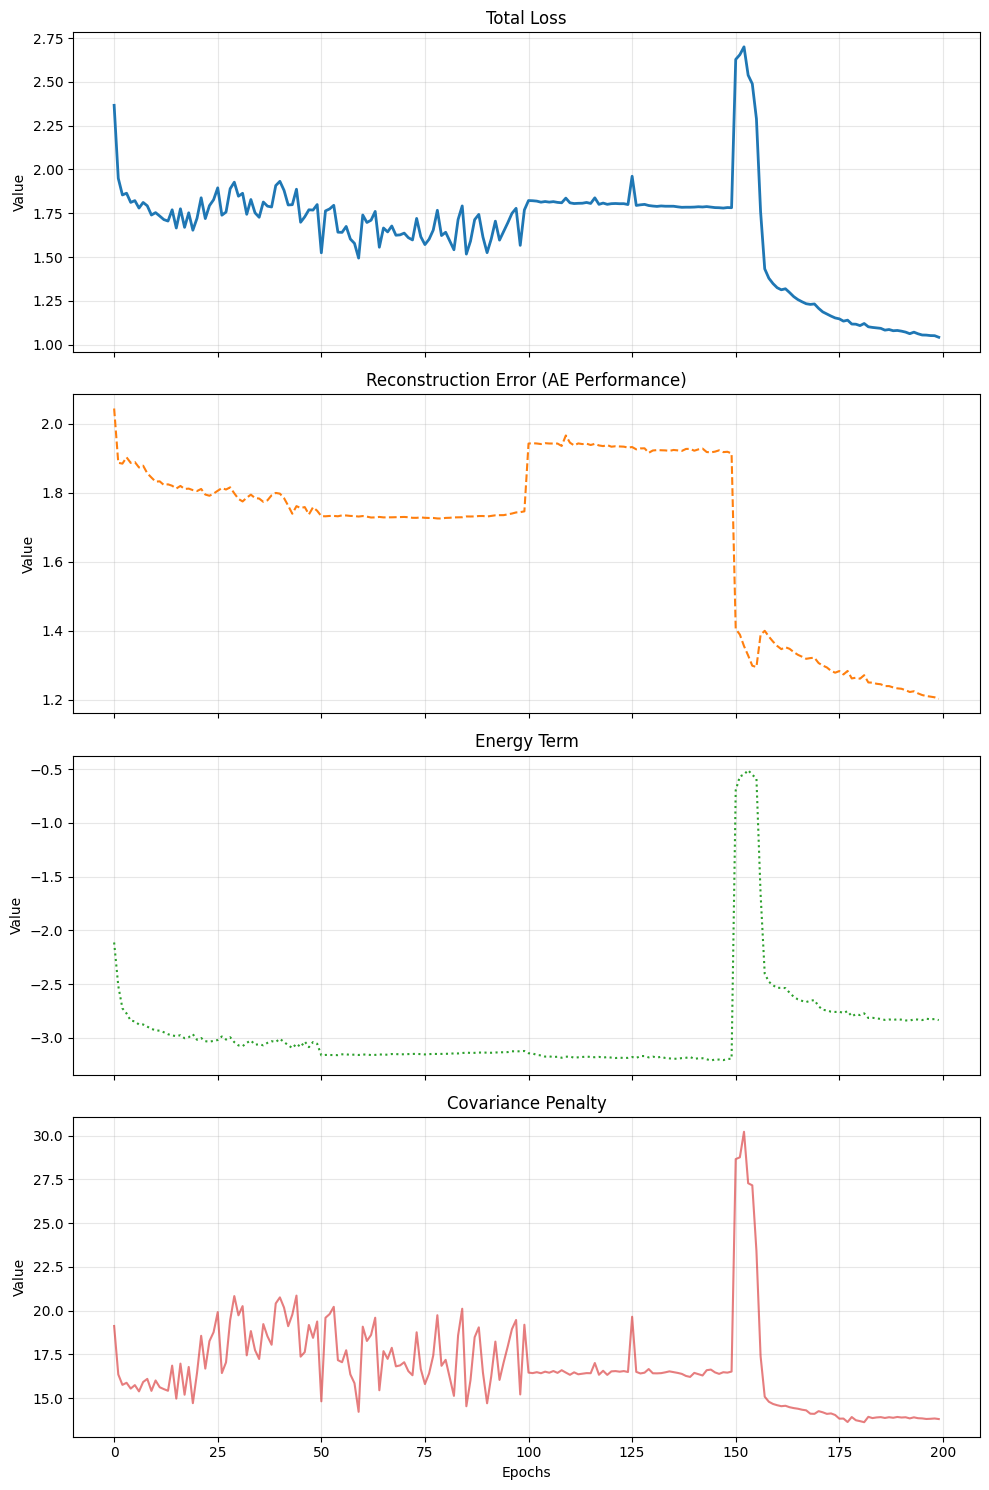

In [30]:
plot_loss_history(history)

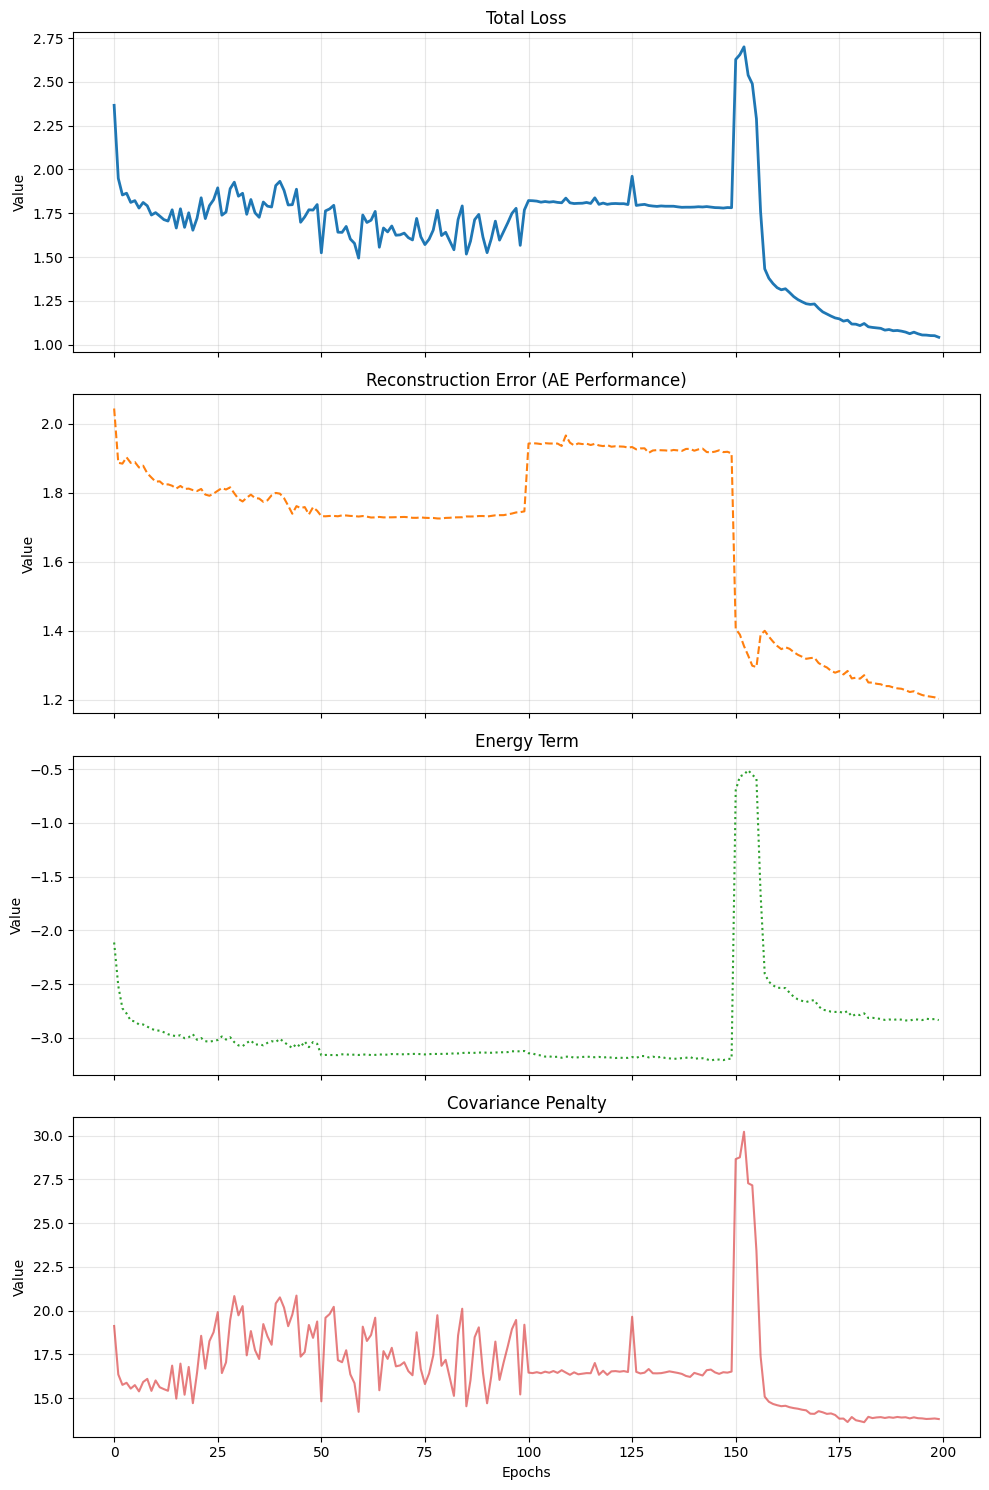

In [46]:
filename = 'best_history_loss.pkl'
with open(filename, 'rb') as f:
    loaded_history = pickle.load(f)
plot_loss_history(loaded_history)


In [33]:
torch.save(model.state_dict(), "DAGMM_best.pth")

In [64]:
model.load_state_dict(torch.load("DAGMM_best.pth"))
model.eval()

DAGMM(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=60, bias=True)
    (3): Tanh()
    (4): Linear(in_features=60, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=10, bias=True)
    (7): Tanh()
    (8): Linear(in_features=10, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=60, bias=True)
    (5): Tanh()
    (6): Linear(in_features=60, out_features=120, bias=True)
    (7): Tanh()
    (8): Linear(in_features=120, out_features=41, bias=True)
  )
  (estim_net): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=4, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [70]:
optimal_thresh_mcc = find_optimal_mcc_threshold(model, X_val, y_val)

--- DAGMM Validation (MCC Criterion) ---
Best Matthews Correlation Coefficient: 0.6202
Optimal Threshold: 17518.1914


In [69]:
optimal_thresh_F1 = find_optimal_f1_threshold(model, X_val, y_val)

--- Risultats of Validation ---
PR-AUC (Average Precision): 1.0000
Best F1-Score: 0.9986
Optimal th: 2.4276



--- Performances on Test Set ---
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97     97189
     Anomaly       1.00      1.00      1.00   1962915

    accuracy                           1.00   2060104
   macro avg       0.98      0.99      0.98   2060104
weighted avg       1.00      1.00      1.00   2060104



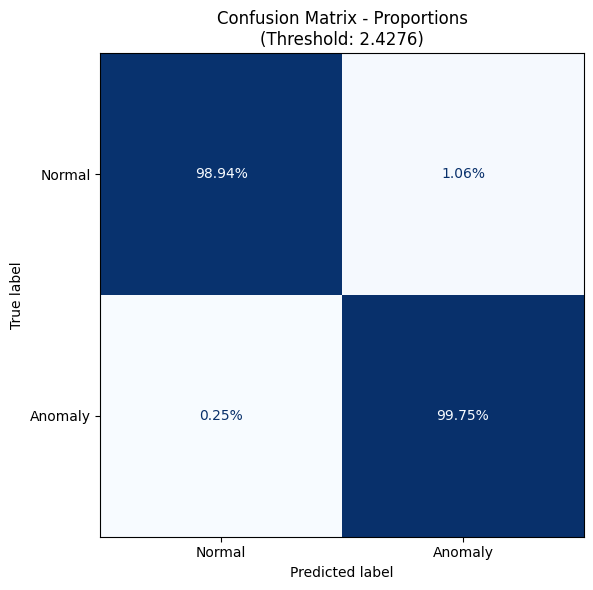

In [71]:
evaluate_performance(model, X_test, y_test, optimal_thresh_F1)

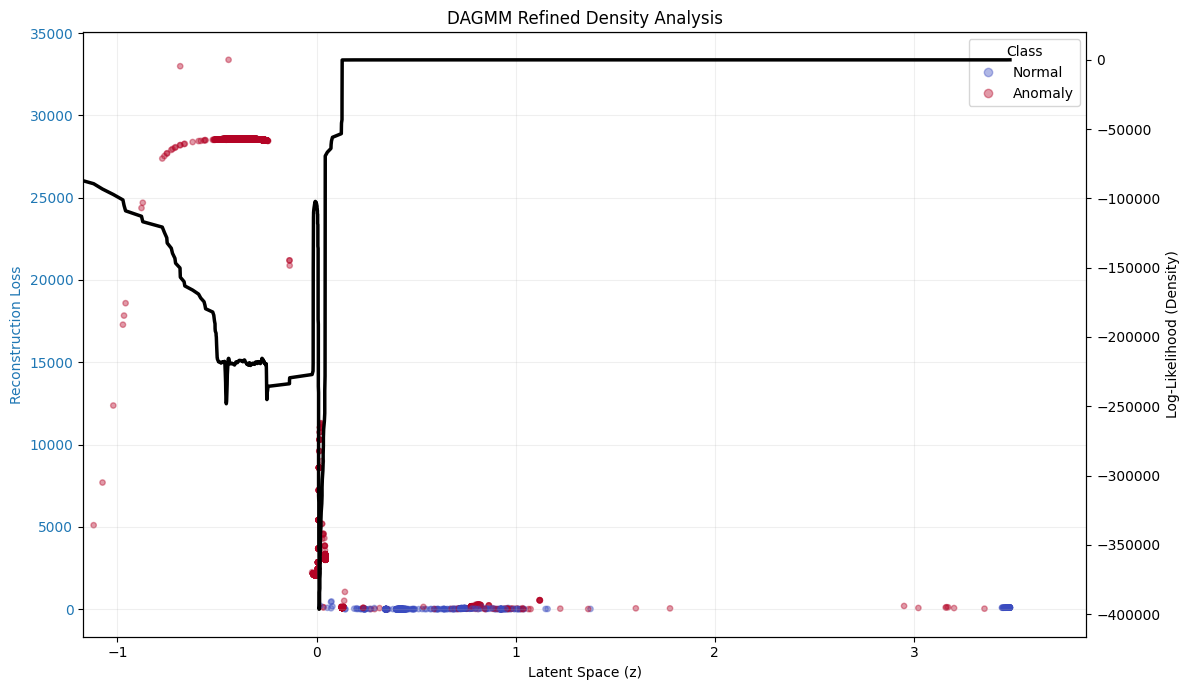

In [54]:
def plot_refined_dagmm_analysis(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        X_tensor = X_test.to(device)
        x_rec, z_combined, gamma = model(X_tensor) 
        
        rec_loss = torch.sum((X_tensor - x_rec)**2, dim=1).cpu().numpy()

        z_latent = z_combined[:, 0].cpu().numpy() 
        
        energy, _ = model.compute_energy(z_combined, flag=False)
        log_likelihood = -energy.cpu().numpy()

    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    fig, ax1 = plt.subplots(figsize=(12, 7))

    scatter = ax1.scatter(z_latent, rec_loss, c=y_true, cmap='coolwarm', 
                          alpha=0.4, s=15, label='Samples')
    
    x_min, x_max = np.percentile(z_latent, [0.5, 99.5])
    padding = (x_max - x_min) * 0.1
    ax1.set_xlim(x_min - padding, x_max + padding)
    
    ax1.set_xlabel('Latent Space (z)')
    ax1.set_ylabel('Reconstruction Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.2)

    ax2 = ax1.twinx()
    
    sort_idx = np.argsort(z_latent)
    z_sorted = z_latent[sort_idx]
    ll_sorted = log_likelihood[sort_idx]
    
    ll_smooth = gaussian_filter1d(ll_sorted, sigma=20)
    
    ax2.plot(z_sorted, ll_smooth, color='black', linewidth=2.5, label='Density Profile')
    ax2.set_ylabel('Log-Likelihood (Density)', color='black')
    
    plt.title('DAGMM Refined Density Analysis')
    
    handles, labels = scatter.legend_elements()
    ax1.legend(handles, ['Normal', 'Anomaly'], loc="upper right", title="Class")
    
    fig.tight_layout()
    plt.show()

plot_refined_dagmm_analysis(model, X_test[:10000], y_test[:10000])

# BANCHMARK MODELS

## PCA

In [61]:
class My_PCA():
    def __init__(self):
        self.U = None
        self.L = None
        self.mean = None


    def fit(self, X):
        #Compute the covariance matrix. 
        X_ = np.asarray(X)
        self.mean = np.mean(X_, axis=0)
        X_c = X_ - self.mean
        C = (X_c.T @ X_c) / (X_c.shape[0] - 1)
        self.L, self.U = np.linalg.eigh(C)

        idx = np.argsort(self.L)[::-1]
        self.L = self.L[idx]
        self.U = self.U[:,idx]

        return self.L, self.U
    
    def transform(self, X, d):
        X_ = np.asarray(X)
        X_c = X_-self.mean
        return X_c @ self.U[:,:d]
    
    def inv_transform(self, X):
        d = X .shape[1]
        X_reconstructed = X @ self.U[:, :d].T
        return X_reconstructed + self.mean

def get_recon(model,x,d):
    return model.inv_transform(model.transform(x,d))

def get_threashold(X_o, X_rec, y):

    reconstruction_errors = np.mean((X_o - X_rec)**2, axis=1)

    y_true = ((y != 'normal.') & (y != 'normal')).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true, reconstruction_errors)
    pr_auc = average_precision_score(y_true, reconstruction_errors)

    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_threshold = thresholds[best_idx]

    print(f"--- Risultati Analisi Ricostruzione ---")
    print(f"PR-AUC (Average Precision): {pr_auc:.4f}")
    print(f"Best F1-Score: {best_f1:.4f}")
    print(f"Threashold: {best_threshold:.4e}")

    return best_threshold, best_f1, pr_auc

def pca_performance(model, d, X_test, y_test, threshold):

    recon = get_recon(model, X_test, d)
    score =  np.mean((X_test - recon)**2, axis=1)
    y_pred = (score > threshold).astype(int)
    
    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    print("\n--- Performances on Test Set (PCA) ---")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true') 
    
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Normal', 'Anomaly'])
    
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.2%')
    ax.set_title(f'Confusion Matrix - Proportions\n(Threshold: {threshold:.4f})')
    
    if disp.im_.colorbar: 
        disp.im_.colorbar.remove()
    ax.grid(False)

    plt.tight_layout()
    plt.show()

def pca_pipeline(d, X_train, X_val, X_test, y_val, y_test):

    model = My_PCA()
    model.fit(X_train)
    recon = get_recon(model, X_val, d)

    th, _, _ = get_threashold(X_val, recon, y_val)

    pca_performance(model, d, X_test, y_test, th)

    plot_pca(model, d, X_test[:5000], y_test[:5000], th)

def plot_pca(model, d, X_test, y_test, threshold):
    X_latent = model.transform(X_test, d)
    z_axis = X_latent[:, 0] 
    
    X_recon = model.inv_transform(X_latent)
    mse_error = np.mean((X_test - X_recon)**2, axis=1)
    
    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    plt.figure(figsize=(12, 6))
    
    plt.scatter(z_axis[y_true == 0], mse_error[y_true == 0], 
                c='tab:blue', alpha=0.4, s=15, label='Normal')
    plt.scatter(z_axis[y_true == 1], mse_error[y_true == 1], 
                c='tab:red', alpha=0.4, s=15, label='Anomaly')
    
    plt.axhline(y=threshold, color='black', linestyle='--', linewidth=2, 
                label=f'Threshold: {threshold:.4e}')
    
    plt.xlabel('First Principal Component ($z_1$)')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title(f'PCA Anomaly Detection (d={d})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log') 
    plt.show()

--- Risultati Analisi Ricostruzione ---
PR-AUC (Average Precision): 0.9740
Best F1-Score: 0.9940
Threashold: 4.3376e-01

--- Performances on Test Set (PCA) ---
              precision    recall  f1-score   support

      Normal       0.99      0.76      0.86     97189
     Anomaly       0.99      1.00      0.99   1962915

    accuracy                           0.99   2060104
   macro avg       0.99      0.88      0.93   2060104
weighted avg       0.99      0.99      0.99   2060104



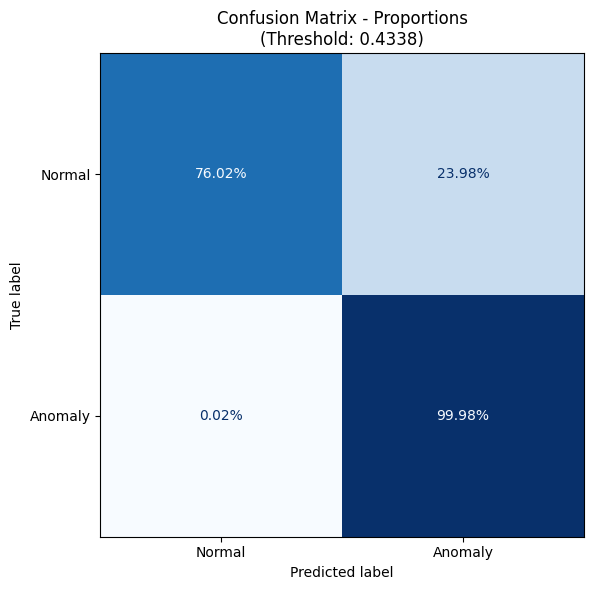

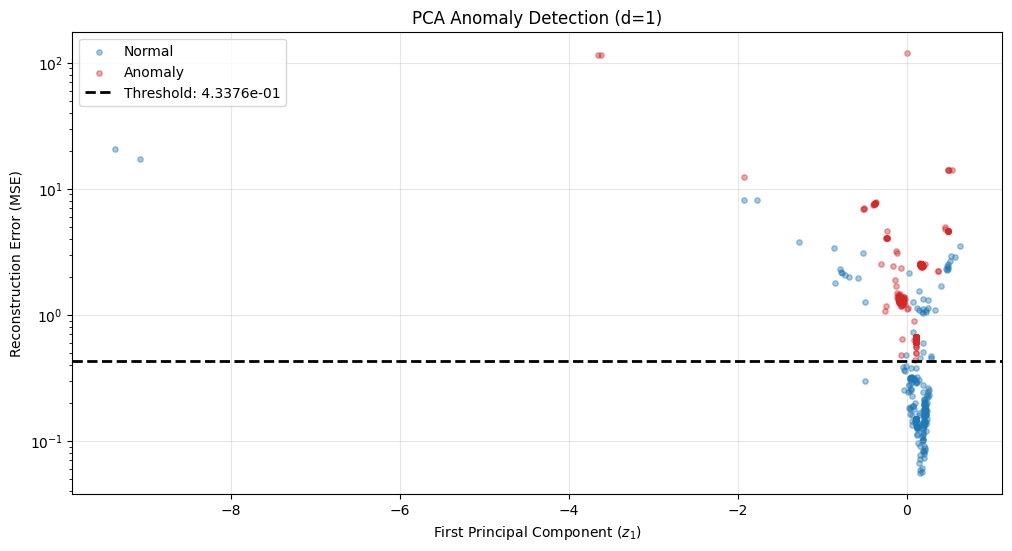

In [62]:
X_train, X_val, X_test, y_val, y_test = split_dataset(X_all, y_all, to_torch=False)
pca_pipeline(1, X_train, X_val, X_test, y_val, y_test)

## GMM AE

In [80]:
class MY_GMM():
    def __init__(self, d):
        self.pi = np.full(d, 1/d)
        self.mu = None
        self.sigma = None
        self.N = None
        self.inv_sigma = None
        self.det_sigma = None
        self.d = d
    
    def Initialize_mu_sigma(self, X):
        self.mu = np.zeros((self.d, X.shape[1]))
        self.N = X.shape[0]
        var = np.var(X, axis=0)
        self.sigma = np.array([np.diag(var) for _ in range(self.d)])
        idx = np.random.choice(X.shape[0], size=self.d, replace=False)
        centers = X[idx]

        for i in range(10):
            sq_c = np.sum(centers**2, axis=1).reshape(-1, 1)
            sq_x = np.sum(X**2, axis=1)
            dot = centers @ X.T
            eu = np.sqrt(np.maximum(sq_c + sq_x - 2*dot, 0))

            cl = np.argmin(eu, axis=0)

            for i in range(self.d):
                idx = np.where(cl==i)
                self.mu[i] = np.mean(X[idx], axis=0)
                
            centers = self.mu

    def _update_cache(self, D):

        self.inv_sigma = np.zeros((self.d, D, D))
        self.det_sigma = np.zeros(self.d)
        for k in range(self.d):
            reg_sigma = self.sigma[k] + np.eye(D) * 1e-6
            self.inv_sigma[k] = np.linalg.inv(reg_sigma)
            det = np.linalg.det(reg_sigma)
            self.det_sigma[k] = det if det > 0 else 1e-30

    def compute_gaussian(self, X, k):
        c_x = X - self.mu[k]
        sig_inv = self.inv_sigma[k]
        det = self.det_sigma[k]

        den = np.sqrt((2 * np.pi)**X.shape[1] * det)
        exponent = -0.5 * np.sum((c_x @ sig_inv) * c_x, axis=1)
        return (1 / (den + 1e-10)) * np.exp(np.clip(exponent, -50, 50))

    def compute_expectation(self, X):
        joint = np.zeros((X.shape[0], self.d))
        for k in range(self.d):
            joint[:, k] = self.pi[k] * self.compute_gaussian(X, k)

        return joint/np.sum(joint, axis=1, keepdims=True) 
    
    def update_params(self, exp, X):
        N, D = X.shape
        n_k = np.sum(exp, axis=0) + 1e-10 # No division for 0
        self.pi = n_k / N

        for k in range(self.d):
            gamma_k = exp[:, k].reshape(-1, 1)
            self.mu[k] = np.sum(gamma_k * X, axis=0) / n_k[k]
            diff = X - self.mu[k] 
            
            new_sigma = ((gamma_k * diff).T @ diff) / n_k[k]
            self.sigma[k] = new_sigma + np.eye(D) * 1e-6 # Add of regularization fo stability

    def compute_log_likelihood(self, X):
        weighted_probs = np.zeros((X.shape[0], self.d))
        for k in range(self.d):
            weighted_probs[:, k] = self.pi[k] * self.compute_gaussian(X, k)
        total_probs = np.sum(weighted_probs, axis=1)
        log_likelihood = np.sum(np.log(total_probs + 1e-10))
        
        return log_likelihood
        
    def fit(self, X, eps=1e-6, max_it=1000, delta=np.inf):
        X = np.asarray(X)
        log_likelihoods = []
        it = 0
        self.Initialize_mu_sigma(X)
        self._update_cache(X.shape[1])
        curr_log = self.compute_log_likelihood(X)

        while delta > eps and it < max_it:
            prev_log = curr_log
            exp = self.compute_expectation(X)
            self.update_params(exp, X)
            self._update_cache(X.shape[1])
            curr_log = self.compute_log_likelihood(X)
            delta = np.abs(curr_log - prev_log)

    def predict(self, X):
        X = np.asarray(X)
        exp = self.compute_expectation(X)
        return np.argmax(exp, axis=1)
    
    def score_samples(self, X):
        if self.inv_sigma is None: self._update_cache(X.shape[1])
        X = np.asarray(X)
        w_probs = np.zeros((X.shape[0], self.d))
        for k in range(self.d):
            w_probs[:, k] = self.pi[k] * self.compute_gaussian(X, k)
        total_probs = np.sum(w_probs, axis=1)
        return np.log(total_probs + 1e-10)

class AE(nn.Module):

    def __init__(self, enc_dims):
        super(AE,self).__init__()
        self.encoder, self.decoder = self.construct_ae(enc_dims)
    
    def construct_ae(self, dimensions):
        enc_layers = []
        n_dims = len(dimensions)
        for i in range(n_dims):
            enc_layers.append(nn.Linear(dimensions[i][0], dimensions[i][1]))
            if i < n_dims-1:
                enc_layers.append(nn.Tanh())

        rev_dims = dimensions[::-1]
        dec_layers = []
        for i in range(n_dims):
            dec_layers.append(nn.Linear(rev_dims[i][1], rev_dims[i][0]))
            if i < n_dims-1:
                dec_layers.append(nn.Tanh())

        return nn.Sequential(*enc_layers), nn.Sequential( *dec_layers)
    
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return z, x_rec

def get_latent_gmm_score(ae_model, gmm_model, X):
    ae_model.eval()
    device = next(ae_model.parameters()).device
    with torch.no_grad():
        if isinstance(X, np.ndarray):
            X_torch = torch.from_numpy(X).float().to(device)
        else:
            X_torch = X.float().to(device)
            
        z = ae_model.encoder(X_torch).cpu().numpy()
        
    return -gmm_model.score_samples(z)

def ae_gmm_F1_threshold(ae_model, gmm_model, X_val, y_val):

    scores = get_latent_gmm_score(ae_model, gmm_model, X_val)
    
    y_true = ((y_val != 'normal.') & (y_val != 'normal')).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    pr_auc = average_precision_score(y_true, scores)

    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    print(f"--- AE + GMM Validation Results ---")
    print(f"PR-AUC: {pr_auc:.4f} | Best F1: {f1_scores[best_idx]:.4f} | Optimal Threashold: {best_threshold}")
    return best_threshold, f1_scores[best_idx], pr_auc

def ae_gmm_threshold_mcc(ae_model, gmm_model, X_val, y_val):

    scores = get_latent_gmm_score(ae_model, gmm_model, X_val)

    y_true = ((y_val != 'normal.') & (y_val != 'normal')).astype(int)

    best_mcc = -1.0
    best_threshold = 0.0

    threshold_candidates = np.linspace(np.min(scores), np.max(scores), 100)
    
    for th in threshold_candidates:
        y_pred = (scores > th).astype(int)
        current_mcc = matthews_corrcoef(y_true, y_pred)
        
        if current_mcc > best_mcc:
            best_mcc = current_mcc
            best_threshold = th
    
    print(f"--- AE + GMM Validation Results (MCC) ---")
    print(f"Best MCC: {best_mcc:.4f}")
    print(f"Optimal Threshold: {best_threshold:.4f}")
    return best_threshold, best_mcc

def ae_gmm_performance(ae_model, gmm_model, X_test, y_test, threshold):
    scores = get_latent_gmm_score(ae_model, gmm_model, X_test)
    y_pred = (scores > threshold).astype(int)
    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    print("\n--- Performances on Test Set (AE + GMM) ---")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))
    
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true') 
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Normal', 'Anomaly'])
    disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='.2%')
    ax.set_title(f'AE+GMM Confusion Matrix\n(Threshold: {threshold:.4f})')
    plt.show()

def plot_latent_density(ae_model, gmm_model, X_test, y_test, threshold):
    ae_model.eval()
    with torch.no_grad():
        X_torch = torch.from_numpy(X_test).float() if isinstance(X_test, np.ndarray) else X_test
        z = ae_model.encoder(X_torch).cpu().numpy()
    
    scores = -gmm_model.score_samples(z)
    y_true = ((y_test != 'normal.') & (y_test != 'normal')).astype(int)
    
    plt.figure(figsize=(12, 6))
    # Usiamo z[:, 0] (la prima dimensione latente) come asse X
    plt.scatter(z[y_true == 0, 0], scores[y_true == 0], c='tab:blue', alpha=0.5, label='Normal')
    plt.scatter(z[y_true == 1, 0], scores[y_true == 1], c='tab:red', alpha=0.5, label='Anomaly')
    plt.axhline(y=threshold, color='black', linestyle='--')
    plt.ylabel('Anomaly Score (-LogLikelihood)')
    plt.xlabel('Latent Dimension $z_1$')
    plt.yscale('symlog')
    plt.legend()
    plt.show()

def train_ae(model, X_train, epochs=50, batch_size=1024, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    tensor_x = torch.Tensor(X_train)
    dataloader = DataLoader(TensorDataset(tensor_x), batch_size=batch_size, shuffle=True)
    
    history = [] 
    
    model.train()
    print(f"Inizio training AE su {device}...")
    for epoch in range(epochs):
        train_loss = 0
        for batch in dataloader:
            x_batch = batch[0].to(device)
            optimizer.zero_grad()
            z, x_rec = model(x_batch) 
            
            loss = criterion(x_rec, x_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_loss = train_loss/len(dataloader)
        history.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    
    return model.cpu(), history

def plot_ae_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history, color='tab:orange', label='Reconstruction Loss (MSE)')
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def ae_gmm_pipeline(ae_dims, n_gmm_comp, X_train, X_val, X_test, y_val, y_test, method='F1'):
    ae_model = AE(ae_dims)
    ae_model, ae_history = train_ae(ae_model, X_train, epochs=50) 
    
    plot_ae_loss(ae_history)
    
    ae_model.eval()
    with torch.no_grad():
            n_sample_gmm = 50000
            device = next(ae_model.parameters()).device
            
            x_sample = X_train[:n_sample_gmm]

            if isinstance(x_sample, np.ndarray):
                x_input = torch.from_numpy(x_sample).float().to(device)
            else:
                x_input = x_sample.float().to(device)
                
            z_train = ae_model.encoder(x_input).cpu().numpy()
        
    gmm_model = MY_GMM(d=n_gmm_comp)
    gmm_model.fit(z_train)

    if method == 'F1':
        th, _, _ = ae_gmm_F1_threshold(ae_model, gmm_model, X_val[:50000], y_val[:50000])
    else:
        th, _ = ae_gmm_threshold_mcc(ae_model, gmm_model, X_val[:50000], y_val[:50000])
    
    ae_gmm_performance(ae_model, gmm_model, X_test[:100000], y_test[:100000], th)
    plot_latent_density(ae_model, gmm_model, X_test[:5000], y_test[:5000], th)
    
    return ae_model, gmm_model, th


In [78]:
X_train, X_val, X_test, y_val, y_test = split_dataset(X_all, y_all, to_torch=False)
input_dim = X_train.shape[1]
print(type(X_train))

<class 'numpy.ndarray'>


Inizio training AE su cuda...
Epoch [10/50], Loss: 0.783920
Epoch [20/50], Loss: 0.649320
Epoch [30/50], Loss: 0.554646
Epoch [40/50], Loss: 0.500116
Epoch [50/50], Loss: 0.483784


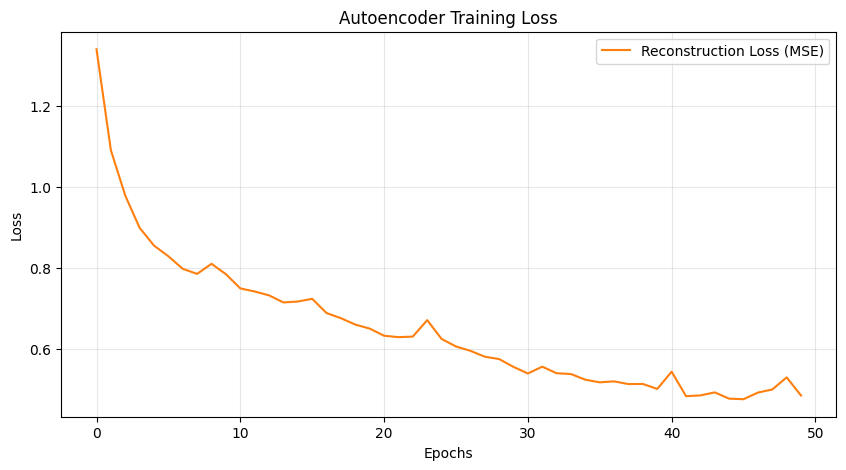

--- AE + GMM Validation Results (MCC) ---
Best MCC: 0.5338
Optimal Threshold: -0.3604

--- Performances on Test Set (AE + GMM) ---
              precision    recall  f1-score   support

      Normal       0.63      0.50      0.56      4740
     Anomaly       0.98      0.99      0.98     95260

    accuracy                           0.96    100000
   macro avg       0.80      0.74      0.77    100000
weighted avg       0.96      0.96      0.96    100000



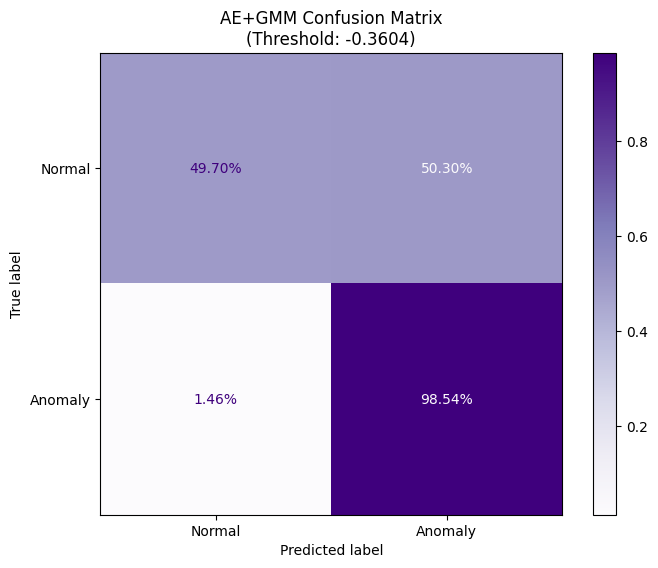

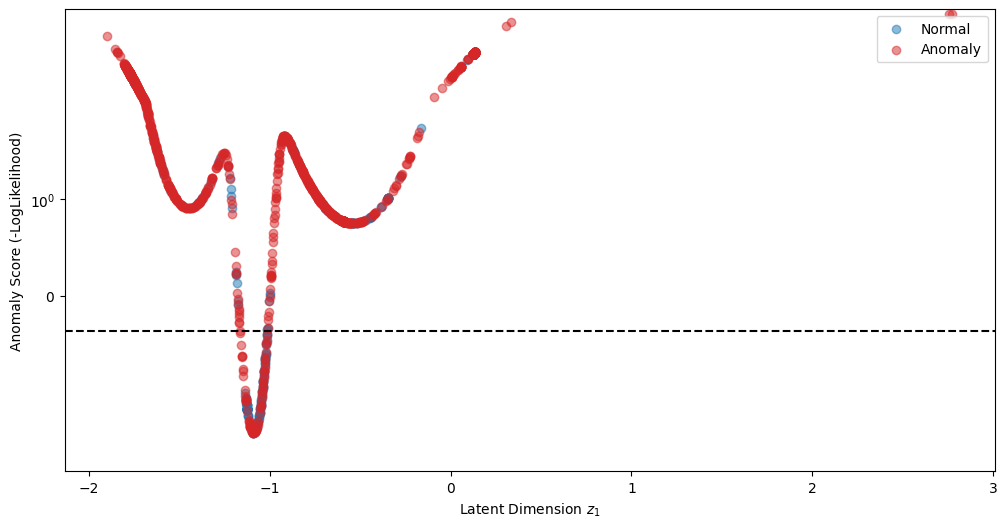

(AE(
   (encoder): Sequential(
     (0): Linear(in_features=41, out_features=120, bias=True)
     (1): Tanh()
     (2): Linear(in_features=120, out_features=60, bias=True)
     (3): Tanh()
     (4): Linear(in_features=60, out_features=30, bias=True)
     (5): Tanh()
     (6): Linear(in_features=30, out_features=10, bias=True)
     (7): Tanh()
     (8): Linear(in_features=10, out_features=1, bias=True)
   )
   (decoder): Sequential(
     (0): Linear(in_features=1, out_features=10, bias=True)
     (1): Tanh()
     (2): Linear(in_features=10, out_features=30, bias=True)
     (3): Tanh()
     (4): Linear(in_features=30, out_features=60, bias=True)
     (5): Tanh()
     (6): Linear(in_features=60, out_features=120, bias=True)
     (7): Tanh()
     (8): Linear(in_features=120, out_features=41, bias=True)
   )
 ),
 np.float64(-0.36041995243565395))

In [79]:
ae_gmm_pipeline([[input_dim, 120], [120,60], [60, 30], [30, 10], [10, 1]] ,4, X_train, X_val, X_test, y_val, y_test, method='MCC')